# Fitting with ChiSquare, Binned Likelihood, and Unbinned Likelihood

This is an introduction to likelihood fits, both binned and unbinned, trying to show the following points:
1. How likelihood fits work, both binned and unbinned.
2. When to use which type of fits, also including ChiSquare.
3. See how the amount of statistics influences the above choice.

Comparisons are naturally done with the ChiSquare. Also, this program serves as an introduction to fitting with iMinuit.

The exercise is made to play around with the (statistics of) the signal and background distributions, so that you can get a feel for the advantages and drawbacks of each method... and make sure that you feel comfortable in applying all three.

### References:
- Barlow: 5.3 + 5.4 + 5.6
- Bevington: Chapter 10

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 23-11-2022 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from tqdm import tqdm

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

Below are some of the general program settings, which are good to have in one place:

In [3]:
r = np.random # Random generator
r.seed(22)    # Set a random seed (but a fixed one)

save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

## Truth values used:

We choose some "god given" values (the "truth") to simulate the data with. The goal of the fits is to estimate these values most accurately, as if you had data, and wanted to extract these values from it.

In [4]:
# Signal parameters:
Npeak = 20000           # Number of random Gaussian points
mu_peak = 3.0        # Peak location
sigma_peak = 0.3     # Peak width

# Background parameters:
Nbkg  = 50000          # Number of random Exponential points
tau_bkg = 3.0        # Decay constant (could be anything!)

## Create the data:

We create some data with a signal peak on an exponential background:

In [5]:
# Create signal:
x_peak = r.normal(loc=mu_peak, scale=sigma_peak, size=Npeak)

# Create background:
x_bkg  = r.exponential(tau_bkg, Nbkg)

# Combine the two:
x_all = np.concatenate((x_peak, x_bkg), axis=0)
if (verbose) :
    print(x_all)

[2.97241502 2.5609948  3.3245375  ... 0.79262992 4.02133849 0.27019322]


## Histogram of data:

Since we are considering both ChiSquare (chi2) and Binned Likelihood (bllh), we start with the histogram, which is the input for both of these. Of course, the Unbinned Likelihood (ullh) doesn't care about binning!

### Note on binning:
It is very important to specify - in a well thought manner - the range and binning to use. Many problems could have been avoided by a few minutes (or even seconds!) of consideration from the beginning. 

In [6]:
# General input:
Nbins = 100
xmin, xmax = 0, 10
binwidth = (xmax-xmin)/Nbins

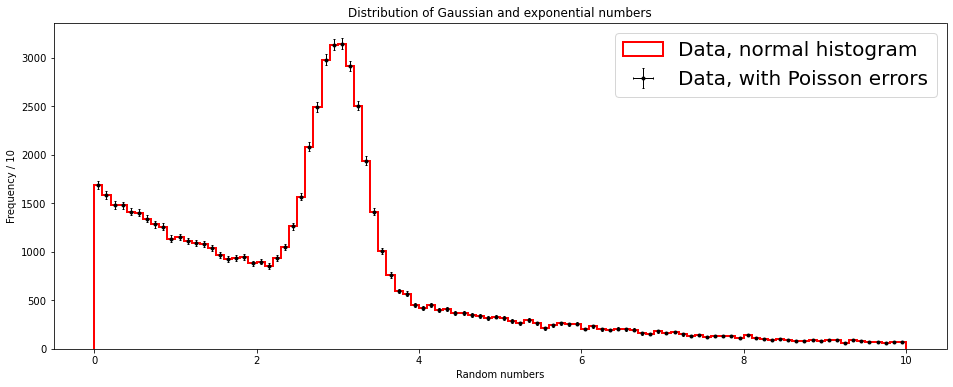

In [7]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Data, normal histogram')

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.
    
mask = y>0
y = y[mask]
sy = sy[mask]
x = x[mask]

# Did you make sure, that all bins were non-zero???
# x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
# y = counts[counts>0]
# sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

# Now create a histogram with uncertainties (better, I would argue):
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers",           # the label of the y axis
       ylabel="Frequency / 10",           # the label of the y axis
       title ="Distribution of Gaussian and exponential numbers")    # the title of the plot
ax.legend(loc='best', fontsize=20);       # could also be # loc = 'upper right' e.g.

## Fit to the data / histogram (1D):

Having created the data, we now want to fit the distributions in three ways:
1. ChiSquare fit
2. Binned Likelihood fit
3. Unbinned Likelihood fit

We first define the function to be fitted with, a Gaussian and and Exponential PDF in this case:

In [8]:
# Define background PDF:
def exp_pdf(x, tau):
    """Exponential with lifetime tau"""
    return 1.0 / tau * np.exp(-x/tau)

In [9]:
# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

In [10]:
# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * exp_pdf(x, tau) + Ngauss * binwidth * gauss_pdf(x, mu, sigma)

In [11]:
# Define your actual fitting function, with both background and signal in,
# which is NOT normalised but has normalisation constants "N" in, but does NOT includes the bin width:
def fit_pdf_llhfit(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * exp_pdf(x, tau) + Ngauss * gauss_pdf(x, mu, sigma)

Having defined our fitting function, we now want to make our three types of fits. Make sure that you understand the difference between the three.

It is important to use the same bins and bounds as the original histogram. In this case we are also treating the number of events/random numbers as being a fit variable.

***

# ChiSquare fit:

### Setting up a fit:

We initialize our fitting object, `chi2fit`, by using the `Chi2Regression` function from External Functions. You can also define your own Chi2 function (see introduction to plotting and fitting in Week0 and below). This first takes the function to fit as input, then the input data.
Following this, we make a Minuit object, i.e. the minimisation itself. This is done using __[iMinuit](https://iminuit.readthedocs.io/en/latest/)__ which is a Python-wrapper for the wonderful minimization tool Minuit developed by CERN. Minuit requires the fitting object (here "chi2fit") and then GOOD input values and fitting options. Finally, we ask Minuit to actually find the minimum, and we have added a check to see, if this converged or not.

In [12]:
#Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(Nexp, tau, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x, Nexp, tau, Ngauss, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2_owncalc, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

<ipython-input-12-6c1b700d5042>:14: InitialParamWarning: errordef is not given, defaults to 1.
  minuit_chi2 = Minuit(chi2_owncalc, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 92.95                      │       Ncalls = 107 (107 total)       │
│ EDM = 3.24e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nexp   │  49.81e3  │  0.26e3   │            │            │         │         │       │
│ 1 │ tau    │   3.005   │   0.018   │            │            │         │         │       │
│ 2 │ Ngauss │  20.09e3  │  0.18e3   │            │            │         │         │       │
│ 3 │ mu     │  3.0013   │  0.0031   │            │            │         │         │       │
│ 4 │ sigma  │  0.3078   │  0.0028   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

#### Extracting fit results - values and $\chi^2$:

Once the fit has converged, the results and $\chi^2$ probability should be evaluated.

In [13]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: Nexp = 49805.05774 +/- 261.81203
Fit value: tau = 3.00456 +/- 0.01823
Fit value: Ngauss = 20094.36459 +/- 184.01275
Fit value: mu = 3.00134 +/- 0.00306
Fit value: sigma = 0.30785 +/- 0.00279
Chi2 value: 92.9   Ndof = 95    Prob(Chi2,Ndof) = 0.540


#### Drawing fit result on top of data:

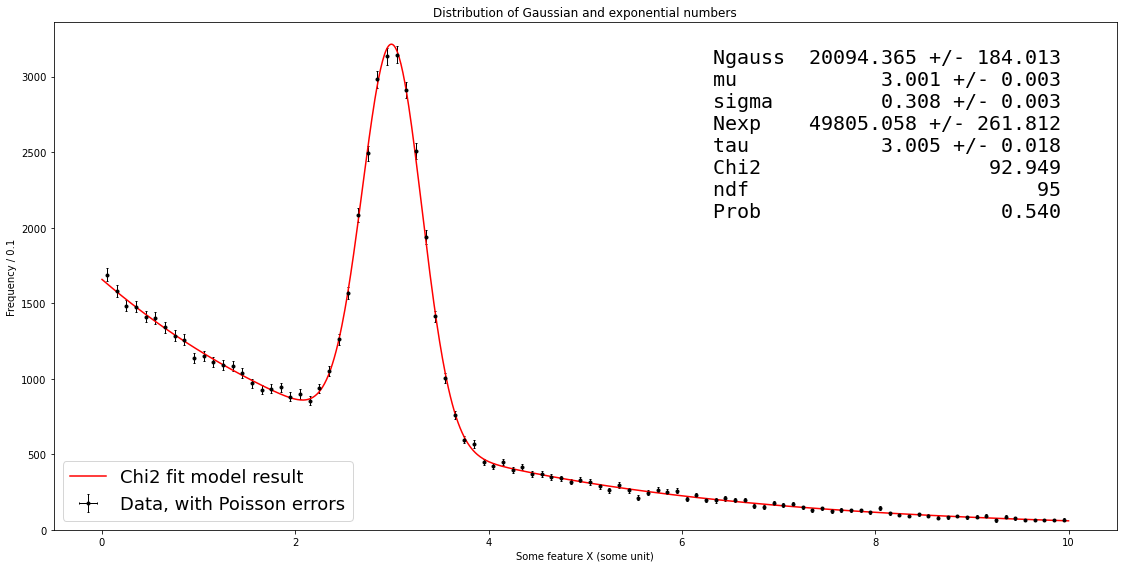

In [14]:
# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel="Frequency / 0.1",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Nexp':     [minuit_chi2.values['Nexp'], minuit_chi2.errors['Nexp']],
     'tau':         [minuit_chi2.values['tau'], minuit_chi2.errors['tau']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

# Binned Likelihood fit:

Next we try to fit the same data with the same function in a *binned likelihood fit*. Note that the fitting object now takes the x-values themselves (not a histogram), but requires numbers of bins and a range/bound.

In [15]:
bllhfit = BinnedLH(fit_pdf_llhfit, x_all, bins=Nbins, bound=(xmin, xmax), extended=True)
minuit_bllh = Minuit(bllhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_bllh.errordef = 0.5     # Value for likelihood fits
minuit_bllh.migrad()           # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 46.3                       │       Ncalls = 107 (107 total)       │
│ EDM = 7.67e-06 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nexp   │  49.94e3  │  0.26e3   │            │            │         │         │       │
│ 1 │ tau    │   3.014   │   0.018   │            │            │         │         │       │
│ 2 │ Ngauss │  20.08e3  │  0.18e3   │            │            │         │         │       │
│ 3 │ mu     │  3.0014   │  0.0031   │            │            │         │         │       │
│ 4 │ sigma  │  0.3063   │  0.0028   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

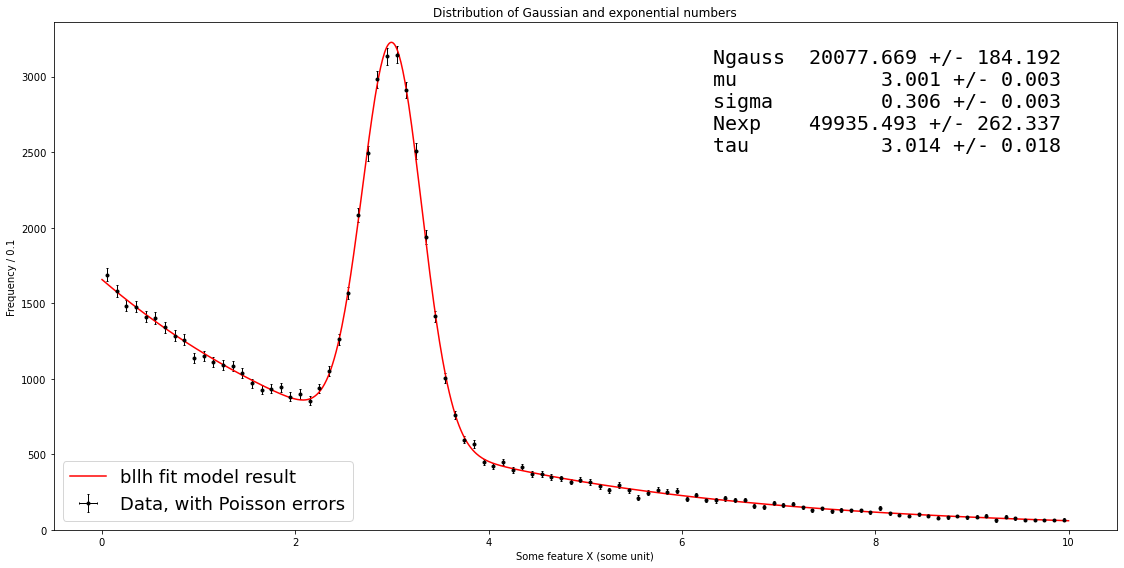

In [16]:
# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel="Frequency / 0.1",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_bllh.values[:]), '-r', label='bllh fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_bllh.values['Ngauss'], minuit_bllh.errors['Ngauss']],
     'mu':       [minuit_bllh.values['mu'], minuit_bllh.errors['mu']],
     'sigma':       [minuit_bllh.values['sigma'], minuit_bllh.errors['sigma']],
     'Nexp':     [minuit_bllh.values['Nexp'], minuit_bllh.errors['Nexp']],
     'tau':         [minuit_bllh.values['tau'], minuit_bllh.errors['tau']],
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

# Unbinned Likelihood fit:

For the *unbinned likelihood fit*, the input is again the x-values themselves, and bounds are possible, but no binning is suggested, as this is... well... unbinned.

In [17]:
ullhfit = UnbinnedLH(fit_pdf_llhfit, x_all, bound=(xmin, xmax), extended=True)
minuit_ullh = Minuit(ullhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_ullh.errordef = 0.5     # Value for likelihood fits
minuit_ullh.migrad()           # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.689e+05                 │       Ncalls = 116 (116 total)       │
│ EDM = 1.27e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nexp   │  49.94e3  │  0.26e3   │            │            │         │         │       │
│ 1 │ tau    │   3.013   │   0.018   │            │            │         │         │       │
│ 2 │ Ngauss │  20.08e3  │  0.18e3   │            │            │         │         │       │
│ 3 │ mu     │  3.0015   │  0.0030   │            │            │         │         │       │
│ 4 │ sigma  │  0.3062   │  0.0028   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

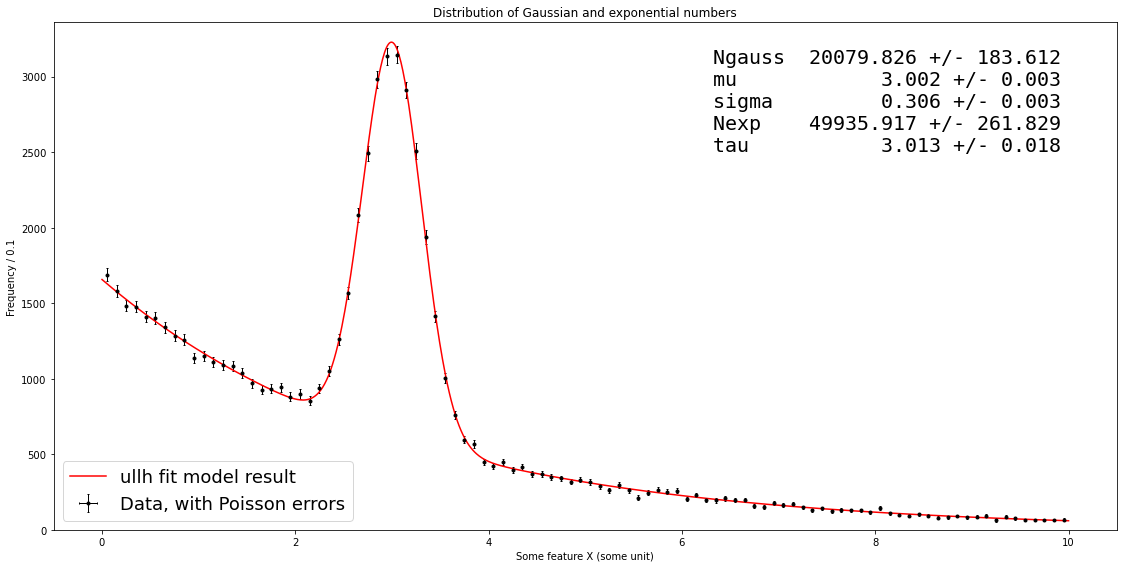

In [18]:
# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel="Frequency / 0.1",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_ullh.values[:]), '-r', label='ullh fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_ullh.values['Ngauss'], minuit_ullh.errors['Ngauss']],
     'mu':       [minuit_ullh.values['mu'], minuit_ullh.errors['mu']],
     'sigma':       [minuit_ullh.values['sigma'], minuit_ullh.errors['sigma']],
     'Nexp':     [minuit_ullh.values['Nexp'], minuit_ullh.errors['Nexp']],
     'tau':         [minuit_ullh.values['tau'], minuit_ullh.errors['tau']],
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

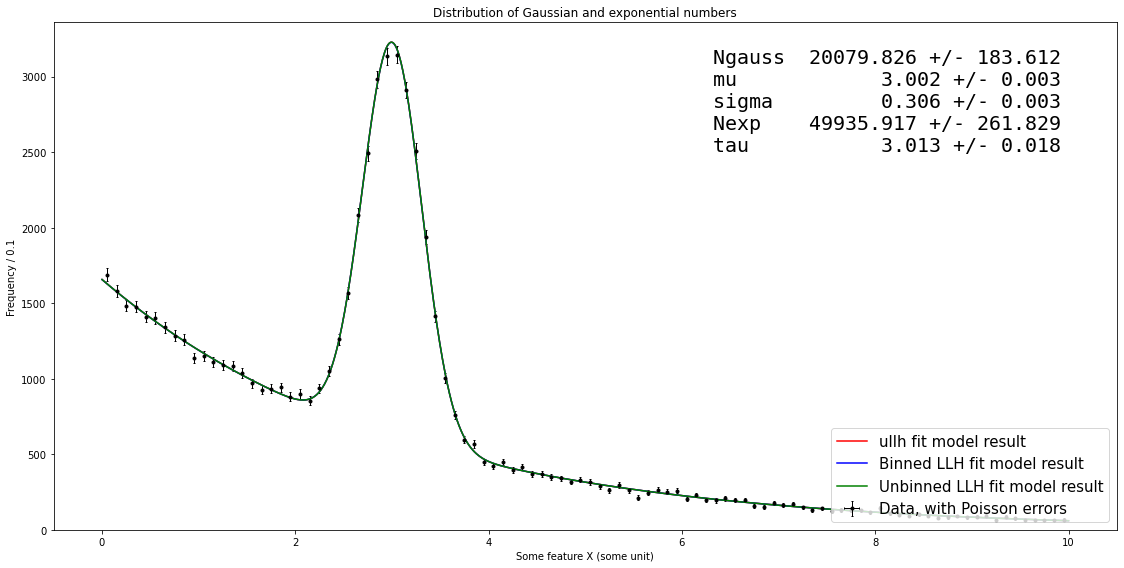

In [19]:
if (not minuit_bllh.fmin.is_valid) :
    print("  WARNING: The Binned Likelihood fit DID NOT converge!!! ")    

if (not minuit_ullh.fmin.is_valid) :
    print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")

# Notice how both results are plotted with the "usual" PDF, as the fit parameters should be correct/similar. 
ax.plot(x_axis, fit_pdf(x_axis, *minuit_bllh.values[:]), '-b', label='Binned LLH fit model result') 
ax.plot(x_axis, fit_pdf(x_axis, *minuit_ullh.values[:]), '-g', label='Unbinned LLH fit model result') 
ax.legend(loc='lower right',fontsize=15)
fig    

In [20]:
orig_llh = minuit_ullh.fval
print(orig_llh)

-568862.6130854889


# Questions:

This exercise is meant for you to see to what extend the three fitting methods give the same results when varying the input parameters, especially when the number of signal and background events is low, and also when the binning is (too) coarse.

1) Start by drawing all three fits on top of the data. Do they (by eye) give the same result, and does the fit generally look "good"? How do you judge that? Also, compare the fitted values of the three fits, and see if they agree within uncertainties?

Example solution: 

They do indeed by eye look the same, and the reduced chi-squared value (chi-squared/ndof) is close to 1, and the probability is between 0.1 and 0.99. For the BLLH and UBLLH fits, the data points and their errors are well covered by the fit, therefore it looks good. The values of the fit parameters also agree within the uncertainties.

2) Now repeat question 1) for lower statistics cases, for example Ngauss = 20 and Nexp = 50. See to what extend the different methods yields reasonable results (i.e. in accordance with the input values). You will encounter problems to be mended by yourself, such as empty bins (should not be passed to the ChiSquare dividing by "observed events", but is fine for the LLH fits) and poor initial values.
Possibly also alter the number of bins to 50 or 25 - is that a good choice? Why/why not?



---

### Advanced question:

3) Knowing the PDFs used for producing the data, try to see, if you can produce a goodness-of-fit measure for the unbinned likelihood fit by repeating this type of fit many times on (re-)simulated data.

3) Knowing the PDFs used for producing the data, try to see, if you can produce a goodness-of-fit measure for the unbinned likelihood fit by repeating this type of fit many times on (re-)simulated data.

In [21]:
Ntimes = 1000

fit_vals = np.zeros((6,Ntimes))
  
    
for i in tqdm(range(Ntimes)):

    # Create signal:
    x_peak2 = r.normal(loc=mu_peak, scale=sigma_peak, size=Npeak)
    # Create background:
    x_bkg2  = r.exponential(tau_bkg, Nbkg)
    # Combine the two:
    x_all2 = np.concatenate((x_peak2, x_bkg2), axis=0)

    # do the fit 
    ullhfit = UnbinnedLH(fit_pdf_llhfit, x_all2, bound=(xmin, xmax), extended=True)
    minuit_ullh = Minuit(ullhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
    minuit_ullh.errordef = 0.5     # Value for likelihood fits
    minuit_ullh.migrad()    
    
    exp, tau, Ngauss, mu, sigma = minuit_ullh.values[:]
    
    llh = minuit_ullh.fval

    fit_vals[:,i] = exp, tau, Ngauss, mu, sigma, llh
    
    #fit_vals[:,i] = exp, tau, Ngauss, mu, sigma 

100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]


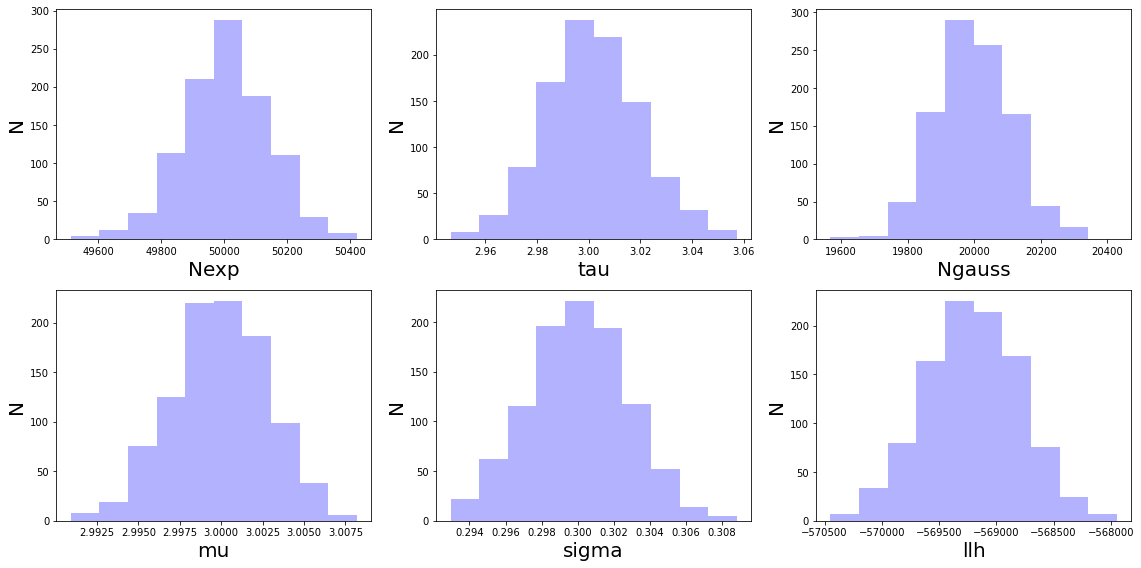

In [22]:
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8))


titles = ['Nexp', 'tau', 'Ngauss', 'mu', 'sigma', 'llh']

for i,ax,title in zip(range(len(fit_vals[:,0])),axes.flatten(),titles):
    ax.hist(fit_vals[i,:],alpha=0.3,color='blue')
    ax.set_ylabel('N',fontsize=20)
    ax.set_xlabel(title,fontsize=20)
fig.tight_layout()
plt.show()

In [23]:
data = (fit_vals[-1,:]) # ullh values 


# getting data of the histogram
count, bins_count = np.histogram((data), bins=50)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)

To get the probability, we want to integrate the CDF of the likelihoods from the original ullh value upwards.

The probability of the ULLH fit is 0.68


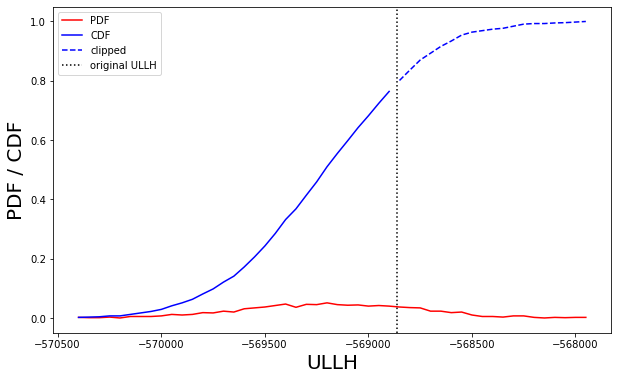

In [24]:
ix_sel = bins_count[1:]>orig_llh 

clipped_cdf_xaxis = bins_count[1:][ix_sel]


# plotting PDF and CDF

plt.figure(figsize=(10,6))
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:][~ix_sel], cdf[~ix_sel], label="CDF",c='blue')
plt.plot(clipped_cdf_xaxis,cdf[ix_sel],label='clipped',c='blue',ls='dashed')
plt.axvline(orig_llh, ls='dotted',c='black',label='original ULLH')
plt.xlabel('ULLH',fontsize=20)
plt.ylabel('PDF / CDF',fontsize=20)
plt.legend()


prob_tot = np.trapz(y=cdf, x=bins_count[1:])
prob_ullh = np.trapz(y=cdf[ix_sel], x=clipped_cdf_xaxis)

final_prob = prob_ullh/prob_tot

print(f"The probability of the ULLH fit is {(final_prob):.2f}")


4) Improve on the printing of results on the plots to better align and have a choice of decimals :-)

example solution: see code above :)

# Learning points:

The exercise is meant as an illustration of the three main fitting paradigms:
1. ChiSquare (binned)
2. Likelihood (binned)
3. Likelihood (unbinned)

While the ChiSquare is almost always recommendable to start out with, low statistics makes it non-optimal. If possible, use an unbinned likelihood, and if the data is already binned, use a binned likelihood.